In [1]:
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from time import gmtime, strftime
from datetime import timedelta

def creatURL(idN, t):
    string = "http://ec2-54-175-179-28.compute-1.amazonaws.com/get_thinktron_data.php?device_id={}&year_month={}".format(idN,t)
    return string    

def query_data(arg1):
    r = requests.get(arg1) # URL path
    soup = BeautifulSoup(r.text,'lxml')
    a = list(soup.find_all('p'))

    # Split the list through the regular expression
    d = re.split('\s+|,|<br/>|<p>|</p>|sec',str(a))

    # Remove the '' element from the list
    d = list(filter(lambda zz: zz != '', d)) 

    # Remove the '=' element from the list
    d = list(filter(lambda zz: zz != '=', d))

    # Remove the '[' & ']' element from the list
    try:
        d.remove(']')
        d.remove('[')
    except:
        pass
    
    return d


def is_number(num):
    pattern = re.compile(r'^[-+]?[-0-9]\d*\.\d*|[-+]?\.?[0-9]\d*$')
    result = pattern.match(num)
    if result:
        return True
    else:
        return False
    

def data_Preprocess(inputqD):
    colName=['id', 'time', 'weather', 'air', 'acceleration', 'cleavage', 'incline', 'field1', 'field2', 'field3']
    df   = pd.DataFrame(columns=colName)
    _df  = pd.DataFrame(columns=colName)
    _lst = ""

    # Data preprocessing
    for ii in range(0,len(inputqD)-2):    
        if (not is_number(inputqD[ii])) & (not is_number(inputqD[ii+1])):        
            col = inputqD[ii]
            if col == "reboot":
                _df['field1'] = "reboot"
            else:
                _df[col] = None

        elif (not is_number(inputqD[ii])):
            col = inputqD[ii]
            add = 1
            while is_number(qD[ii + add]):
                if not (qD[ii + add + 1] in colName):
                    _lst += str(inputqD[ii + add]) + ","
                else:
                    _lst += str(inputqD[ii + add])                
                add += 1
            _df[col] = [_lst]        
        _lst = ""

        if (col == colName[-1]):
            col = ""
            df = df.append(_df, ignore_index=True)
    return df

def get_incline_dataPoint(anaDf):
    valListX = []
    valListY = []
    for ii in range(0,len(anaDf)):
        inclineLst = anaDf["incline"][ii].split(",")
        valListX.append(float(inclineLst[0]))
        valListY.append(float(inclineLst[1]))            
    return valListX, valListY

def get_incline_product(anaDf):
    inclineLst = anaDf["incline"][len(anaDf)-1].split(",")
    prodctVal = 1
    for ii in range(0,len(inclineLst)):
        prodctVal *= float(inclineLst[ii])            
    return prodctVal


2007  Done.


D:\PythonProgm\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


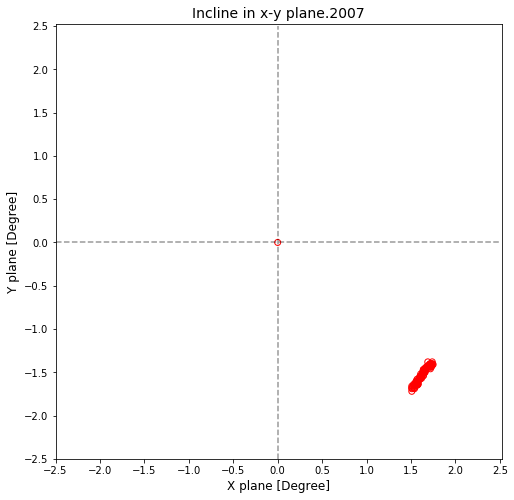

In [17]:
#location = "NewTaipei"
#location = "Taipei"
location = "TestMode"
idNumList = []
DBName =""
queryDate = strftime("%Y%m%d")
quertMonth = strftime("%Y%m")
now = strftime("%Y%m%d%H%M")

if (location.lower() == "newtaipei"):
    idNumDict  = [{'name':'馥記山莊','id':'2015'},
                  {'name':'秀岡第一','id':'3015'},
                  {'name':'老爺山莊','id':'2011'},
                  {'name':'怡園社區','id':'3014'},
                  {'name':'台北小城','id':'3001'},
                  {'name':'秀岡陽光','id':'3029'},
                  {'name':'薇多綠雅','id':'3028'},
                  {'name':'達觀鎮B6','id':'3022'},
                  {'name':'花園點二','id':'2005'}, 
                  {'name':'達觀鎮A1','id':'3019'},
                  {'name':'圓富華城','id':'3021'},              
                  {'name':'淺水灣莊','id':'3023'},
                  {'name':'詩畫大樓','id':'3016'},
                  {'name':'伯爵晶鑽','id':'3025'},
                  {'name':'花園點一','id':'2009'},
                  {'name':'勘農別墅','id':'2010'},
                  {'name':'國家別墅','id':'3017'},
                  {'name':'台北山城','id':'3024'},
                  {'name':'歡喜居易','id':'3013'},
                  {'name':'伯爵一期','id':'3020'},
                  {'name':'迎旭山莊','id':'3018'}]
    DBName = "New Taipei"
elif (location.lower() == "taipei"):
    idNumDict  = [{'name':'政大自強','id':'2007'},
                  {'name':'政大山頂','id':'2001'},
                  {'name':'中山北七','id':'2008'},
                  {'name':'公訓新牆','id':'2003'},
                  {'name':'公訓舊牆','id':'2002'},
                  {'name':'松德院北','id':'2021'},
                  {'name':'松德院南','id':'2020'}]
    DBName = "Taipei"
elif (location.lower() == "testmode"):
    idNumDict  = [{'name':'政大自強','id':'2007'}]
    DBName = "Test Mode"
    
else:
    print("No such name.")    
    


flag = 0
for ii in range(len(idNumDict)):       
    URLstr = creatURL(str(idNumDict[ii]["id"]),queryDate) # Format in (id_Num, yyyymm)
    qD = query_data(URLstr)
    
    
    if ("No" in qD) & ("results" in qD):
        print("{} Offline over 1 day".format(idNumDict[ii]["id"]))
        URLstr = creatURL(str(idNumDict[ii]["id"]),quertMonth)
        qD = query_data(URLstr)
    
    arrDf = data_Preprocess(qD)
    X, Y = get_incline_dataPoint(arrDf) 
    productVal = get_incline_product(arrDf)
    
    
    if (abs(productVal) < 1e-4):
        writingStr = "Outliers occur\nTime: {} Incline: {} Status: {}".\
        format(arrDf.tail(1)["time"].iloc[0],\
               arrDf.tail(1)["incline"].iloc[0],\
               arrDf.tail(1)["field1"].iloc[0])                                                     
    else:
        writingStr = "Device OK"
        

    queryFid = "{}_{}_outlier_incline_List.txt".format(now, DBName)    
    
    if (flag == 0):
        with open(queryFid, "a") as file:
            file.write("-----Device outlier (incline meter)-----")
            file.write("\n")
            file.write("Name of project: " + DBName)
            file.write("\n")
            file.write("Query time: {}".format(strftime("%Y/%m/%d %H:%M")))
            file.write("\n")
            flag = 1   
    with open(queryFid, "a") as file:
        writing = "{}    {}    {}".format(idNumDict[ii]["name"],idNumDict[ii]["id"],writingStr)
        file.write(writing)
        file.write("\n")
    print(str(idNumDict[ii]["id"]) + "  Done.")
    
    
    # Scatter analysis
    fig = plt.figure(num=1, figsize=[8,8])
    plt.scatter(X, Y, marker = 'o', facecolors='none', edgecolors='r')

    
    plt.subplot(1, 1, 1)
    ax1 = plt.subplot(111)
    ax1.set_title('Incline in x-y plane.{}'.format(idNumDict[ii]["id"]), fontdict = {'fontsize':14})

    rag = 2.5
    plt.plot([-rag, rag],[0, 0],'k--', alpha = 0.4)
    plt.plot([0, 0],[-rag, rag],'k--', alpha = 0.4)
    
    ragAdd = rag*0.01
    plt.ylim([-rag + ragAdd, rag + ragAdd])
    plt.xlim([-rag + ragAdd, rag + ragAdd])
    plt.yticks(np.arange(-rag, rag+ ragAdd, step = 0.5))
    plt.xticks(np.arange(-rag, rag+ ragAdd, step = 0.5))
    plt.xlabel('X plane [Degree]', fontdict = {'fontsize':12})
    plt.ylabel('Y plane [Degree]', fontdict = {'fontsize':12})
    fig.savefig('outlier_scatter_ana' + idNumDict[ii]["id"] + '_' + now +'.jpg', dpi= 400)
